# Gaussian Process Regression in Pytorch

*Thomas Viehmann*, <tv@lernapparat.de>
Modelled after GPFlow Regression notebook by James Hensman


In [10]:
from matplotlib import pyplot
%matplotlib inline
import IPython
import torch
import numpy
import sys, os
sys.path.append(os.path.join(os.getcwd(),'..'))

pyplot.style.use('ggplot')

In [11]:
import candlegp
import candlegp.training.hmc


Let's have a regression example

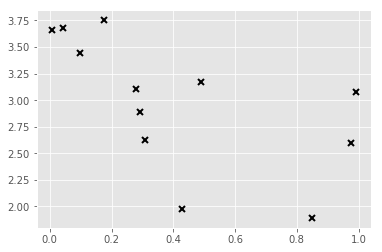

In [12]:
N = 12
X = torch.rand(N,1).double()
Y = (torch.sin(12*X) + 0.6*torch.cos(25*X) + torch.randn(N,1).double()*0.1+3.0).squeeze(1)
pyplot.figure()
pyplot.plot(X.numpy(), Y.numpy(), 'kx', mew=2)


## Creating the model

Not adapted to the data yet...

In [19]:
k = candlegp.kernels.Matern52(1, lengthscales=torch.tensor([0.3], dtype=torch.double),
                              variance=torch.tensor([1.0], dtype=torch.double))
mean = candlegp.mean_functions.Linear(torch.tensor([1], dtype=torch.double), torch.tensor([0], dtype=torch.double))
m = candlegp.models.GPR(X, Y.unsqueeze(1), kern=k, mean_function=mean)
m.likelihood.variance.set(torch.tensor([0.01], dtype=torch.double))
m

Parameter,Value,Prior,ParamType
mean_function.A,[[1.]],None,Param
mean_function.b,[0.],None,Param
kern.variance,[1.],None,PositiveParam
kern.lengthscales,[0.3],None,PositiveParam
likelihood.variance,[0.01],None,PositiveParam


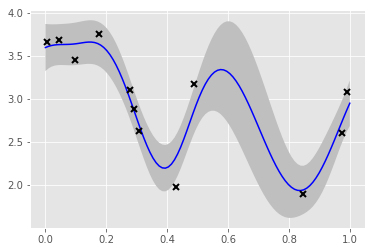

In [20]:
xstar = torch.linspace(0,1,100).double()
mu, var = m.predict_y(xstar.unsqueeze(1))
cred_size = (var**0.5*2).squeeze(1)

mu = mu.squeeze(1)
pyplot.plot(xstar.numpy(),mu.data.numpy(),'b')
pyplot.fill_between(xstar.numpy(),mu.data.numpy()+cred_size.data.numpy(), mu.data.numpy()-cred_size.data.numpy(),facecolor='0.75')
pyplot.plot(X.numpy(), Y.numpy(), 'kx', mew=2)


## Maximum-A-Posteriori

One commonly used approach to model selection is to maximize the marginal log likelihood. This is the "gp" equivalent of a maximum-likelihood estimate.

In [21]:
opt = torch.optim.LBFGS(m.parameters(), lr=1e-2, max_iter=40)
def eval_model():
    obj = m()
    opt.zero_grad()
    obj.backward()
    return obj

for i in range(50):
    obj = m()
    opt.zero_grad()
    obj.backward()
    opt.step(eval_model)
    if i%5==0:
        print(i,':',obj.item())
m

0 : 37.44138372573719
5 : 7.5857069647482565
10 : 6.650935910168812
15 : 6.619075539256768
20 : 6.6145839888125275
25 : 6.614004695780689
30 : 6.613928909529414
35 : 6.613918778320371
40 : 6.613917663627206
45 : 6.613917591721911


Parameter,Value,Prior,ParamType
mean_function.A,[[-1.26990141]],None,Param
mean_function.b,[3.49111625],None,Param
kern.variance,[0.26755383],None,PositiveParam
kern.lengthscales,[0.03386912],None,PositiveParam
likelihood.variance,[8.18978548e-09],None,PositiveParam


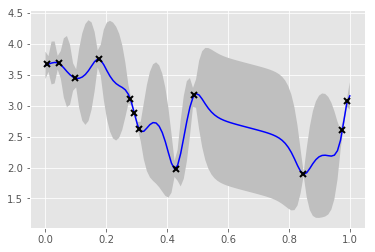

In [22]:
xstar = torch.linspace(0,1,100).double()
mu, var = m.predict_y(xstar.unsqueeze(1))
cred_size = (var**0.5*2).squeeze(1)

mu = mu.squeeze(1)
pyplot.plot(xstar.numpy(),mu.data.numpy(),'b')
pyplot.fill_between(xstar.numpy(),mu.data.numpy()+cred_size.data.numpy(), mu.data.numpy()-cred_size.data.numpy(),facecolor='0.75')
pyplot.plot(X.numpy(), Y.numpy(), 'kx', mew=2)


## Hamiltonian Monte Carlo

We can go more Bayesian by putting a prior on the parameters and do Hamiltonian Monte Carlo to draw parameters.

In [11]:
k2 = candlegp.kernels.RBF(1, lengthscales=torch.tensor([0.3], dtype=torch.double),
                              variance=torch.tensor([1.0], dtype=torch.double))
mean2 = candlegp.mean_functions.Linear(torch.tensor([1], dtype=torch.double), torch.tensor([0], dtype=torch.double))

m2 = candlegp.models.GPR(X, Y.unsqueeze(1), kern=k2, mean_function=mean2)
m2.load_state_dict(m.state_dict())
dt = torch.double
m2.likelihood.variance.prior = candlegp.priors.Gamma(1.0,1.0, dtype=dt)
m2.kern.variance.prior = candlegp.priors.Gamma(1.0,1.0, dtype=dt)
m2.kern.lengthscales.prior = candlegp.priors.Gamma(1.0,1.0,dtype=dt)
m2.mean_function.A.prior = candlegp.priors.Gaussian(0.0,10.0, dtype=dt)
m2.mean_function.b.prior = candlegp.priors.Gaussian(0.0,10.0, dtype=dt)
print("likelihood with priors",m2().item())
m2

likelihood with priors 39.17809987930393


Parameter,Value,Prior,ParamType
mean_function.A,[[-0.71790932]],"N(0.0,10.0)",Param
mean_function.b,[3.27777302],"N(0.0,10.0)",Param
kern.variance,[0.8319501],"Ga(1.0,1.0)",PositiveParam
kern.lengthscales,[0.09421412],"Ga(1.0,1.0)",PositiveParam
likelihood.variance,[2.17245288e-09],"Ga(1.0,1.0)",PositiveParam


In [12]:
# res = candlegp.training.hmc.hmc_sample(m2,500,0.2,burn=50, thin=10)
res = candlegp.training.hmc.hmc_sample(m2,50,0.2,burn=50, thin=10)

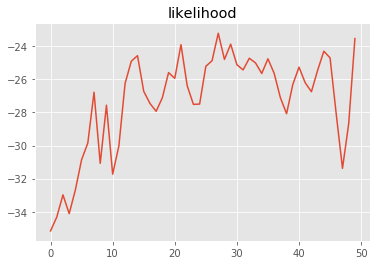

In [13]:
pyplot.plot(res[0]); pyplot.title("likelihood");

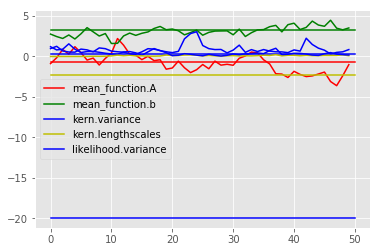

In [14]:
for (n,p0),p,c in zip(m.named_parameters(),res[1:],['r','g','b','y','b']):
  pyplot.plot(torch.stack(p).squeeze().numpy(), c=c, label=n)
  pyplot.plot((0,len(p)),(p0.data.view(-1)[0],p0.data.view(-1)[0]), c=c)
pyplot.legend();

## Plotting simulated functions

(Note that the simulations are for the de-noised functions - i.e. without the noise contribution of the likelihood.)

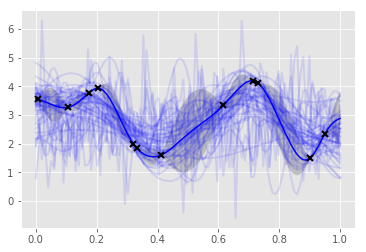

In [16]:
xstar = torch.linspace(0,1,100).double()
mc_params = torch.stack([torch.cat(p, dim=0).view(-1) for p in res[1:]], dim=1)

allsims = []
for ps in mc_params[:50]:
    for mp, p in zip(m2.parameters(), ps):
        with torch.no_grad():
            mp.set(p)
    allsims.append(m2.predict_f_samples(xstar.unsqueeze(1), 1).squeeze(0).t())
allsims = torch.cat(allsims, dim=0)

pyplot.plot(xstar.numpy(),allsims.data.numpy().T, 'b', lw=2, alpha=0.1)

mu, var = m.predict_y(xstar.unsqueeze(1))
cred_size = (var**0.5*2).squeeze(1)
mu = mu.squeeze(1)
pyplot.plot(xstar.numpy(),mu.data.numpy(),'b')
pyplot.fill_between(xstar.numpy(),mu.data.numpy()+cred_size.data.numpy(), mu.data.numpy()-cred_size.data.numpy(),facecolor='0.75')
pyplot.plot(X.numpy(), Y.numpy(), 'kx', mew=2)


# Sparse Regression

In [23]:
k3 = candlegp.kernels.RBF(1, lengthscales=torch.tensor([0.3], dtype=torch.double),
                              variance=torch.tensor([1.0], dtype=torch.double))
mean3 = candlegp.mean_functions.Linear(torch.tensor([1], dtype=torch.double), torch.tensor([0], dtype=torch.double))
m3 = candlegp.models.SGPR(X, Y.unsqueeze(1), k3, X[:7].clone(), mean_function=mean3)
m3.likelihood.variance.set(torch.tensor([0.01], dtype=torch.double))
m3


Parameter,Value,Prior,ParamType
Z,[[0.42762262] [0.27919608] [0.09710813] [0.04383558] [0.17524767] [0.30686706] [0.29161185]],None,Param
mean_function.A,[[1.]],None,Param
mean_function.b,[0.],None,Param
kern.variance,[1.],None,PositiveParam
kern.lengthscales,[0.3],None,PositiveParam
likelihood.variance,[0.01],None,PositiveParam


In [24]:
opt = torch.optim.LBFGS(m3.parameters(), lr=1e-2, max_iter=40)
def eval_model():
    obj = m3()
    opt.zero_grad()
    obj.backward()
    return obj

for i in range(50):
    obj = m3()
    opt.zero_grad()
    obj.backward()
    opt.step(eval_model)
    if i%5==0:
        print(i,':',obj.item())
m3


0 : 208.88640588744306
5 : 24.124737262281542
10 : 8.375756526589
15 : 8.065662861865206
20 : 8.057095573850445
25 : 8.027454914992646
30 : 7.898941077274772
35 : 7.827157316384053
40 : 7.826362880513787
45 : 7.826276326797827


Parameter,Value,Prior,ParamType
Z,[[0.98911724] [0.42457725] [0.17690738] [0.0330425 ] [0.29635502] [0.84857596] [0.49014805]],None,Param
mean_function.A,[[-1.16073767]],None,Param
mean_function.b,[3.45984289],None,Param
kern.variance,[0.09911261],None,PositiveParam
kern.lengthscales,[0.0534057],None,PositiveParam
likelihood.variance,[0.12981673],None,PositiveParam


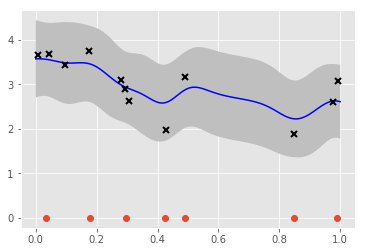

In [25]:
xstar = torch.linspace(0,1,100).double()
mu, var = m3.predict_y(xstar.unsqueeze(1))
cred_size = (var**0.5*2).squeeze(1)

mu = mu.squeeze(1)
pyplot.plot(xstar.numpy(),mu.data.numpy(),'b')
pyplot.fill_between(xstar.numpy(),mu.data.numpy()+cred_size.data.numpy(), mu.data.numpy()-cred_size.data.numpy(),facecolor='0.75')
pyplot.plot(X.numpy(), Y.numpy(), 'kx', mew=2)
pyplot.plot(m3.Z.data.numpy(), torch.zeros(m3.Z.size(0)).numpy(),'o')